## Effect Size Simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import *
from time import time

In [2]:
def pooled_sd(arr1, arr2):
    n1 = len(arr1)
    n2 = len(arr2)
    sd1 = np.std(arr1)
    sd2 = np.std(arr2)
    return (((n1 - 1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2-2))**0.5

In [286]:
def get_bootstrap_indices(arr, n=1000, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    return np.random.choice(np.arange(len(arr)), size=[sample_size,n], replace=True)

def bootstrap_samples(y_pred, y_true=None, n=1000, sample_size=None):
    indices = get_bootstrap_indices(y_pred, n=n, sample_size=sample_size)
    out = {'y_pred_bootstrap': y_pred[indices]}
    if y_true is not None:
        out['y_true_bootstrap'] = y_true[indices]
    return out

def apply_fun(bootstrap_samples, fun, requires_y_true=True):
    if requires_y_true:
        zipped = zip(bootstrap_samples['y_true_bootstrap'].T, 
                     bootstrap_samples['y_pred_bootstrap'].T)
        return np.array([fun(true, pred) for true, pred in zipped])
    else:
        return np.array([fun(s) for s in bootstrap_samples['y_pred_bootstrap'].T])

def cohens_d(arr1, arr2, verbose=False):
    if verbose:
        print(f'Mean Statistic 1: {np.mean(arr1)}', 
              f'Mean Statistic 2: {np.mean(arr2)}')
    return (np.mean(arr1)-np.mean(arr2)) / pooled_sd(arr1, arr2)

def compare(samples1, samples2, fun, requires_y_true=None, verbose=True):
    if requires_y_true is None:
        requires_y_true = False
        if 'y_true_bootstrap' in samples1:
            requires_y_true = True
    out1 = apply_fun(samples1, fun, requires_y_true)
    out2 = apply_fun(samples2, fun, requires_y_true)
    out = cohens_d(out1, out2, verbose=verbose)
    return out

## Simulation 1

In [257]:
dist1 = lambda size: np.random.normal(loc=10, 
                                      scale=2, 
                                      size=size)
dist2 = lambda size: np.random.normal(loc=0, 
                                      scale=2, 
                                      size=size)
val1 = dist1(10000)
val2 = dist2(1000)

In [258]:
samples1 = bootstrap_samples(val1, sample_size=None)
samples2 = bootstrap_samples(val2, sample_size=None)
#compare(samples1, samples2, np.mean)

### simple case - calculate whether distributions are different

* Sample each distribution N times
* calculate the effect size between the two distributions
* this gives you CI around the effect size

Text(0.5, 1.0, '4.886291602681316')

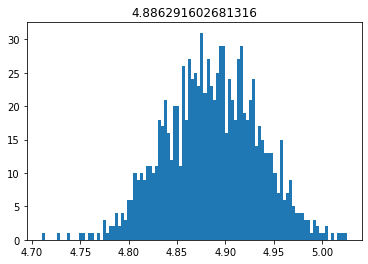

In [259]:
tmp1 = samples1['y_pred_bootstrap']
tmp2 = samples2['y_pred_bootstrap']

effect_sizes = [cohens_d(tmp1[:,i], tmp2[:, i]) for i in range(tmp1.shape[1])]
h=plt.hist(effect_sizes, bins=100)
plt.title(np.mean(effect_sizes))

### What if each sample just gave one number? Like the accuracy

In this case, you calculate the statistic for each sample. For instance, let's say we calculate the mean. Each of these gives a distribution of means. We get the pooled standard deviation

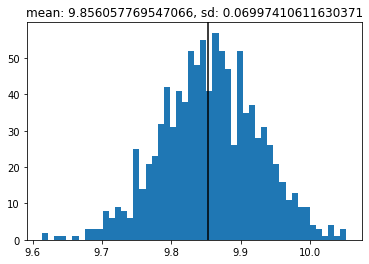

In [261]:
statistic1 = np.mean(samples1['y_pred_bootstrap'], 0)
statistic2 = np.mean(samples2['y_pred_bootstrap'], 0)

diffs = statistic1-statistic2
_ = plt.hist(diffs, bins=50)
plt.title(f'mean: {diffs.mean()}, sd: {diffs.std()}')

sample_estimate = (np.mean(val1)-np.mean(val2))
plt.axvline(sample_estimate, color='k')

## Simulation 2

In [231]:
#config
dist1 = lambda size: np.random.exponential(size=size)
dist2 = lambda size: np.random.normal(loc=np.random.rand(), 
                                      scale=np.random.rand(), 
                                      size=size)
n1 = 10000
n2 = 10000

In [232]:
def gen_pred(dists, ns):
    return [d(n) for d,n in zip(dists,ns)]

true1, true2 = gen_pred([dist1, dist1], [n1, n2])
pred1 = true1 + np.random.normal(size=n1)*.4


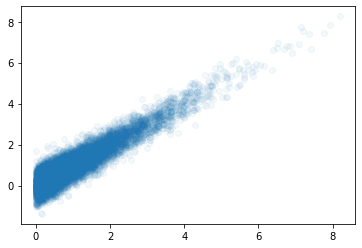

In [233]:
plt.scatter(true1, pred1, alpha=.05)

### First Sim

In [297]:
pred1 = true1 + np.random.normal(size=n1)*.4
pred2 = true2 + np.random.normal(size=n2)*.5

n_boot = 2000
sample_size=1000
samples1 = bootstrap_samples(pred1, true1, 
                             n_boot, sample_size=sample_size)
samples2 = bootstrap_samples(pred2, true2, 
                             n_boot, sample_size=sample_size)

fun = r2_score
requires_y_true = True
out1 = apply_fun(samples1, fun, requires_y_true)
out2 = apply_fun(samples2, fun, requires_y_true)

Text(0.5, 1.0, '3.766937991050949, 0.029009527929095235')

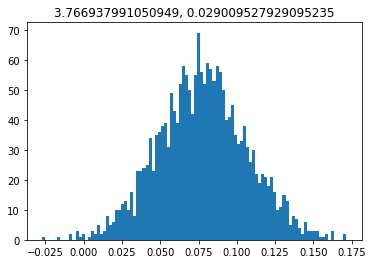

In [298]:
dist = out1-out2
_ = plt.hist(dist, bins=100)
plt.title(f'{cohens_d(out1, out2)}, {np.std(dist)}')

In [308]:
from scipy.stats import norm
abs(norm.ppf(.001))/10000**.5

0.03090232306167813

In [314]:
# convert effect sizes into needed sample size to discover at .05
effects = [0.01, .05, .1] # small, medium, large
p_val = .05
sample_sizes = [(abs(norm.ppf(p_val))/e)**2 for e in effects]
sample_sizes

[27055.434540954146, 1082.2173816381658, 270.55434540954144]

### More parameters

In [236]:
def evaluate(pred1, true1, pred2, true2, n=1000, sample_size=None):
    samples1 = bootstrap_samples(pred1, true1, 1000, sample_size=sample_size)
    samples2 = bootstrap_samples(pred2, true2, 1000, sample_size=sample_size)
    effect_size = compare(samples1, samples2, r2_score, verbose=False)
    return effect_size

In [235]:
noises = np.arange(0,1, .05)

In [9]:
# full sample
start = time()
results = []
for comparison_noise in noises:
    pred1 = true1 + np.random.normal(size=n1)*.4
    pred2 = true2 + np.random.normal(size=n2)*comparison_noise
    results.append(evaluate(pred1, true1, pred2, true2))
full_boot = pd.Series(results, index=noises, name='full')
full_time = time()-start

NameError: name 'samples' is not defined

In [ ]:
series = []
times = []
sample_sizes = np.arange(100,5000, 500)
for sample_size in sample_sizes:
    results = []
    start = time()
    for comparison_noise in noises:
        pred1 = true1 + np.random.normal(size=n1)*.4
        pred2 = true2 + np.random.normal(size=n2)*comparison_noise
        results.append(evaluate(pred1, true1, pred2, true2, sample_size=sample_size))
    series.append(pd.Series(results, index=noises, name=sample_size))
    times.append(time()-start)

In [ ]:
df = pd.concat(series + [full_boot], axis=1)

In [ ]:
df.plot()

In [ ]:
# time taken
pd.Series([full_time] + times, index= ['full'] + list(sample_sizes))